In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
import matplotlib.patches as mpatches
from matplotlib import rcParams

rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # matches Overleaf lmodern
    "mathtext.fontset": "cm",
    "text.latex.preamble": r"\usepackage{lmodern}\usepackage{amsmath}"
})


pd.set_option("display.width", 300)
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', '{:.6f}'.format)

# Load Data

## Load Embeddings

In [2]:
audience_embeddings = pd.read_parquet("NLP Data/Audience Embeddings/rt_audience_embeddings_aggregated.parquet")
critic_embeddings = pd.read_parquet("NLP Data/Critic Embeddings/rt_critic_embeddings_aggregated.parquet")

print(f"Number of movies in audience embeddings data: {audience_embeddings.shape[0]}",
      f"\nNumber of movies in critic embeddings data: {critic_embeddings.shape[0]}")

Number of movies in audience embeddings data: 9116 
Number of movies in critic embeddings data: 9116


## Load Valence Data (Sentiment)

In [3]:
audience_valence = pd.read_json("NLP Data/Audience Sentiment Data/rt_audience_valence_aggregated.json")
critic_valence = pd.read_json("NLP Data/Critic Sentiment Data/rt_critic_valence_aggregated.json")

print(f"Number of movies in audience valence data: {audience_valence.shape[0]}",
      f"\nNumber of movies in critic valence data: {critic_valence.shape[0]}")

Number of movies in audience valence data: 9116 
Number of movies in critic valence data: 9116


## Load 'Movies' Data

In [4]:
movies = pd.read_json("Rotten Tomatoes Reviews/rt_movies_clean.json")

# Merge 'Audience' and 'Critic' Datasets

## Merge 'Audience' and 'Critic' Embeddings

In [5]:
combined_embeddings = pd.merge(left=audience_embeddings.rename(columns={"embeddings": "AudienceEmbeddings"}),
                    right=critic_embeddings.rename(columns={"embeddings": "CriticEmbeddings"}),
                    on="id",
                    how="outer")
combined_embeddings.set_index("id", inplace=True)
combined_embeddings.sort_index(inplace=True)

print(f"Number of rows in combined_embeddings: {combined_embeddings.shape[0]}")

Number of rows in combined_embeddings: 9116


## Merge 'Audience' and 'Critic' Valence Data

In [6]:
combined_valence = pd.merge(left=audience_valence.rename(columns={"AvgValence": "AvgAudienceValence"}),
                            right=critic_valence.rename(columns={"AvgValence": "AvgCriticValence"}),
                             on="id",
                             how="outer")
combined_valence.reset_index(inplace=True, drop=True)

print(f"Number of rows in combined_valence: {combined_valence.shape[0]}")
combined_valence.head()

Number of rows in combined_valence: 9116


,id,AvgAudienceValence,AvgCriticValence
0,10000_bc,-0.208172,-0.410251
1,1000218-accident,0.534362,0.424794
2,10002516-lost_city,0.567837,-0.158982
3,10002635-bridge_of_san_luis_rey,-0.028470,-0.647940
4,10003276-criminal,0.313468,0.281749


# Calculate Divergence/Similarity Metrics

## Calculate Cosine Similarity

In [7]:
combined_embeddings["CosineSimilarity"] = combined_embeddings.apply(lambda row: cosine_similarity([row["AudienceEmbeddings"]], [row["CriticEmbeddings"]])[0][0], axis=1)

# Compartmentalize by Valence and Content Similarity

## Merge Valence and Embeddings data for Grouping

In [8]:
Val_Con_Total = combined_valence.merge(combined_embeddings, on="id", how="inner")[["id", "AvgAudienceValence", "AvgCriticValence", "CosineSimilarity"]]

print(f"Total Rows: {Val_Con_Total.shape[0]}")
Val_Con_Total

Total Rows: 9116


,id,AvgAudienceValence,AvgCriticValence,CosineSimilarity
0,10000_bc,-0.208172,-0.410251,0.902636
1,1000218-accident,0.534362,0.424794,0.901405
2,10002516-lost_city,0.567837,-0.158982,0.888783
3,10002635-bridge_of_san_luis_rey,-0.028470,-0.647940,0.810171
4,10003276-criminal,0.313468,0.281749,0.898567
...,...,...,...,...
9111,zoo,-0.096497,0.213495,0.904870
9112,zookeeper,0.014791,-0.509755,0.904950
9113,zoolander,0.397527,0.176242,0.906266
9114,zoolander_2,-0.361727,-0.426734,0.928039


## Compartmentalise Data into Groups Based on Valence Difference and Review Content Divergence

### Relative

In [9]:
cutoff = 0.25

# High Valence in both Groups and Similar Review Content
highVal_sameCon = Val_Con_Total[(Val_Con_Total["AvgAudienceValence"] > Val_Con_Total["AvgAudienceValence"].quantile(1-cutoff)) &
                                (Val_Con_Total["AvgCriticValence"] > Val_Con_Total["AvgCriticValence"].quantile(1-cutoff)) &
                                (Val_Con_Total["CosineSimilarity"] > Val_Con_Total["CosineSimilarity"].quantile(1-cutoff))]

highVal_sameCon["group"] = "highVal_sameCon"

# High Valence in both Groups and Diverging Review Content
highVal_diffCon = Val_Con_Total[(Val_Con_Total["AvgAudienceValence"] > Val_Con_Total["AvgAudienceValence"].quantile(1-cutoff)) &
                                (Val_Con_Total["AvgCriticValence"] > Val_Con_Total["AvgCriticValence"].quantile(1-cutoff)) &
                                (Val_Con_Total["CosineSimilarity"] <= Val_Con_Total["CosineSimilarity"].quantile(cutoff))]

highVal_diffCon["group"] = "highVal_diffCon"

# Neutral Valence in both Groups and Similar Review Content
neutVal_sameCon = Val_Con_Total[(Val_Con_Total["AvgAudienceValence"] > Val_Con_Total["AvgAudienceValence"].quantile(0.5-cutoff/2)) & (Val_Con_Total["AvgAudienceValence"] <= Val_Con_Total["AvgAudienceValence"].quantile(0.5+cutoff/2)) &
                                (Val_Con_Total["AvgCriticValence"] > Val_Con_Total["AvgCriticValence"].quantile(0.5-cutoff/2)) & (Val_Con_Total["AvgCriticValence"] <= Val_Con_Total["AvgCriticValence"].quantile(0.5+cutoff/2)) &
                                (Val_Con_Total["CosineSimilarity"] > Val_Con_Total["CosineSimilarity"].quantile(1-cutoff))]

neutVal_sameCon["group"] = "neutVal_sameCon"

# Neutral Valence in both Groups and Diverging Review Content
neutVal_diffCon = Val_Con_Total[(Val_Con_Total["AvgAudienceValence"] > Val_Con_Total["AvgAudienceValence"].quantile(0.5-cutoff/2)) & (Val_Con_Total["AvgAudienceValence"] <= Val_Con_Total["AvgAudienceValence"].quantile(0.5+cutoff/2)) &
                                (Val_Con_Total["AvgCriticValence"] > Val_Con_Total["AvgCriticValence"].quantile(0.5-cutoff/2)) & (Val_Con_Total["AvgCriticValence"] <= Val_Con_Total["AvgCriticValence"].quantile(0.5+cutoff/2)) &
                                (Val_Con_Total["CosineSimilarity"] <= Val_Con_Total["CosineSimilarity"].quantile(cutoff))]

neutVal_diffCon["group"] = "neutVal_diffCon"

# Low Valence in both Groups and Similar Review Content
lowVal_sameCon = Val_Con_Total[(Val_Con_Total["AvgAudienceValence"] <= Val_Con_Total["AvgAudienceValence"].quantile(cutoff)) &
                               (Val_Con_Total["AvgCriticValence"] <=  Val_Con_Total["AvgCriticValence"].quantile(cutoff)) &
                               (Val_Con_Total["CosineSimilarity"] > Val_Con_Total["CosineSimilarity"].quantile(1-cutoff))]

lowVal_sameCon["group"] = "lowVal_sameCon"

# Low Valence in both Groups and Diverging Review Content
lowVal_diffCon = Val_Con_Total[(Val_Con_Total["AvgAudienceValence"] <= Val_Con_Total["AvgAudienceValence"].quantile(cutoff)) &
                               (Val_Con_Total["AvgCriticValence"] <= Val_Con_Total["AvgCriticValence"].quantile(cutoff)) &
                               (Val_Con_Total["CosineSimilarity"] <= Val_Con_Total["CosineSimilarity"].quantile(cutoff))]

lowVal_diffCon["group"] = "lowVal_diffCon"

# Define consistent color mapping and legend labels
group_order = [
    "highVal_sameCon",
    "highVal_diffCon",
    "neutVal_sameCon",
    "neutVal_diffCon",
    "lowVal_sameCon",
    "lowVal_diffCon"
]

palette = sns.color_palette("tab10", n_colors=6)
group_palette = dict(zip(group_order, palette))

leg_labels = [
    "Positive Valence, Similar Content",
    "Positive Valence, Diverging Content",
    "Neutral Valence, Similar Content",
    "Neutral Valence, Diverging Content",
    "Negative Valence, Similar Content",
    "Negative Valence, Diverging Content"
]

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1871/934454500.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highVal_sameCon["group"] = "highVal_sameCon"
/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1871/934454500.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highVal_diffCon["group"] = "highVal_diffCon"
/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1871/934454500.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

### Absolute Valence Cut-Off

In [10]:
cutoff_abs = 0.4
lowEnd_correction = 0.4

# High Valence in both Groups and Similar Review Content
highVal_sameCon_abs = Val_Con_Total[(Val_Con_Total["AvgAudienceValence"] > 1-cutoff_abs) &
                                (Val_Con_Total["AvgCriticValence"] > 1-cutoff_abs) &
                                (Val_Con_Total["CosineSimilarity"] > Val_Con_Total["CosineSimilarity"].quantile(1-cutoff))]

highVal_sameCon_abs["group"] = "highVal_sameCon"

# High Valence in both Groups and Diverging Review Content
highVal_diffCon_abs = Val_Con_Total[(Val_Con_Total["AvgAudienceValence"] > 1-cutoff_abs) &
                                (Val_Con_Total["AvgCriticValence"] > 1-cutoff_abs) &
                                (Val_Con_Total["CosineSimilarity"] <= Val_Con_Total["CosineSimilarity"].quantile(cutoff))]

highVal_diffCon_abs["group"] = "highVal_diffCon"

# Neutral Valence in both Groups and Similar Review Content
neutVal_sameCon_abs = Val_Con_Total[(Val_Con_Total["AvgAudienceValence"] > 0-cutoff_abs/2+lowEnd_correction/4) & (Val_Con_Total["AvgAudienceValence"] <= 0+cutoff_abs/2+lowEnd_correction/4) &
                                (Val_Con_Total["AvgCriticValence"] > 0-cutoff_abs/2+lowEnd_correction/4) & (Val_Con_Total["AvgCriticValence"] <= 0+cutoff_abs/2+lowEnd_correction/4) &
                                (Val_Con_Total["CosineSimilarity"] > Val_Con_Total["CosineSimilarity"].quantile(1-cutoff))]

neutVal_sameCon_abs["group"] = "neutVal_sameCon"

# Neutral Valence in both Groups and Diverging Review Content
neutVal_diffCon_abs = Val_Con_Total[(Val_Con_Total["AvgAudienceValence"] > 0-cutoff_abs/2+lowEnd_correction/4) & (Val_Con_Total["AvgAudienceValence"] <= 0+cutoff_abs/2+lowEnd_correction/4) &
                                (Val_Con_Total["AvgCriticValence"] > 0-cutoff_abs/2+lowEnd_correction/4) & (Val_Con_Total["AvgCriticValence"] <= 0+cutoff_abs/2+lowEnd_correction/4) &
                                (Val_Con_Total["CosineSimilarity"] <= Val_Con_Total["CosineSimilarity"].quantile(cutoff))]

neutVal_diffCon_abs["group"] = "neutVal_diffCon"

# Low Valence in both Groups and Similar Review Content
lowVal_sameCon_abs = Val_Con_Total[(Val_Con_Total["AvgAudienceValence"] <= cutoff_abs-1+lowEnd_correction) &
                               (Val_Con_Total["AvgCriticValence"] <=  cutoff_abs-1+lowEnd_correction) &
                               (Val_Con_Total["CosineSimilarity"] > Val_Con_Total["CosineSimilarity"].quantile(1-cutoff))]

lowVal_sameCon_abs["group"] = "lowVal_sameCon"

# Low Valence in both Groups and Diverging Review Content
lowVal_diffCon_abs = Val_Con_Total[(Val_Con_Total["AvgAudienceValence"] <= cutoff_abs-1+lowEnd_correction) &
                               (Val_Con_Total["AvgCriticValence"] <= cutoff_abs-1+lowEnd_correction) &
                               (Val_Con_Total["CosineSimilarity"] <= Val_Con_Total["CosineSimilarity"].quantile(cutoff))]

lowVal_diffCon_abs["group"] = "lowVal_diffCon"

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1871/4128947505.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highVal_sameCon_abs["group"] = "highVal_sameCon"
/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1871/4128947505.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highVal_diffCon_abs["group"] = "highVal_diffCon"
/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1871/4128947505.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

# Merge Group Data

In [11]:
#merged = pd.concat([highVal_sameCon, highVal_diffCon, neutVal_sameCon, neutVal_diffCon, lowVal_sameCon, lowVal_diffCon], ignore_index=True)

merged = pd.concat([highVal_sameCon_abs, highVal_diffCon_abs, neutVal_sameCon_abs, neutVal_diffCon_abs, lowVal_sameCon_abs, lowVal_diffCon_abs], ignore_index=True)

## Group Sizes

In [12]:
print(f"Number of Movies with High Valence for Both Groups with,\n\tSimilar Review Content: {merged[merged['group'] == 'highVal_sameCon'].shape[0]},\n\tDiverging Review Content: {merged[merged['group'] == 'highVal_diffCon'].shape[0]}",
      f"\nNumber of Movies with Neutral Valence for Both Groups with,\n\tSimilar Review Content: {merged[merged['group'] == 'neutVal_sameCon'].shape[0]},\n\tDiverging Review Content: {merged[merged['group'] == 'neutVal_diffCon'].shape[0]}",
      f"\nNumber of Movies with Low Valence for Both Groups with,\n\tSimilar Review Content: {merged[merged['group'] == 'lowVal_sameCon'].shape[0]},\n\tDiverging Review Content: {merged[merged['group'] == 'lowVal_diffCon'].shape[0]}")

Number of Movies with High Valence for Both Groups with,
	Similar Review Content: 486,
	Diverging Review Content: 305 
Number of Movies with Neutral Valence for Both Groups with,
	Similar Review Content: 216,
	Diverging Review Content: 159 
Number of Movies with Low Valence for Both Groups with,
	Similar Review Content: 72,
	Diverging Review Content: 52


# Group Characteristics

## Descriptive Statistics

### High Valence

In [13]:
combined_groups = merged.merge(right=movies, how="left", on="id")

combined_groups[combined_groups["group"] == "highVal_sameCon"].describe(include="all")

,id,AvgAudienceValence,AvgCriticValence,CosineSimilarity,group,title,audienceScore,tomatoMeter,ageRating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,releaseYear,boxOffice
count,486,486.000000,486.000000,486.000000,486,486,486.000000,485.000000,269,486,463,478,485.000000,485,481,486,485.000000,486.000000
unique,486,NaN,NaN,NaN,1,485,NaN,NaN,4,236,434,393,NaN,157,32,397,NaN,NaN
top,1000617-aliens,NaN,NaN,NaN,highVal_sameCon,Beauty and the Beast,NaN,NaN,R,[],2011-11-23T00:00:00.000,2012-11-06T00:00:00.000,NaN,[Drama],English,Pedro Almodóvar,NaN,NaN
freq,1,NaN,NaN,NaN,486,2,NaN,NaN,127,217,4,3,NaN,98,330,6,NaN,NaN
mean,NaN,0.730441,0.741611,0.936010,NaN,NaN,85.627572,93.028866,NaN,NaN,NaN,NaN,110.608247,NaN,NaN,NaN,2002.678351,30461736.059671
std,NaN,0.075082,0.083868,0.009252,NaN,NaN,6.529488,4.767225,NaN,NaN,NaN,NaN,23.292586,NaN,NaN,NaN,18.770571,65362537.281056
min,NaN,0.600195,0.600406,0.921829,NaN,NaN,52.000000,75.000000,NaN,NaN,NaN,NaN,43.000000,NaN,NaN,NaN,1927.000000,1725.000000
25%,NaN,0.672759,0.670820,0.928304,NaN,NaN,81.250000,90.000000,NaN,NaN,NaN,NaN,95.000000,NaN,NaN,NaN,1999.000000,303350.000000
50%,NaN,0.726525,0.733213,0.935373,NaN,NaN,87.000000,94.000000,NaN,NaN,NaN,NaN,107.000000,NaN,NaN,NaN,2009.000000,2350000.000000
75%,NaN,0.790161,0.801415,0.942469,NaN,NaN,90.000000,97.000000,NaN,NaN,NaN,NaN,122.000000,NaN,NaN,NaN,2015.000000,24725000.000000


In [14]:
combined_groups[combined_groups["group"] == "highVal_diffCon"].describe(include="all")

,id,AvgAudienceValence,AvgCriticValence,CosineSimilarity,group,title,audienceScore,tomatoMeter,ageRating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,releaseYear,boxOffice
count,305,305.000000,305.000000,305.000000,305,305,294.000000,305.000000,60,305,263,272,305.000000,305,304,305,300.000000,305.000000
unique,305,NaN,NaN,NaN,1,305,NaN,NaN,3,49,248,255,NaN,64,34,294,NaN,NaN
top,10006950-the_violin,NaN,NaN,NaN,highVal_diffCon,The Violin,NaN,NaN,R,[],2017-05-19T00:00:00.000,2016-08-10T00:00:00.000,NaN,[Documentary],English,Mohammad Rasoulof,NaN,NaN
freq,1,NaN,NaN,NaN,305,1,NaN,NaN,29,245,2,3,NaN,97,168,3,NaN,NaN
mean,NaN,0.816005,0.748543,0.806687,NaN,NaN,79.690476,90.275410,NaN,NaN,NaN,NaN,100.583607,NaN,NaN,NaN,2011.240000,2346455.003279
std,NaN,0.130702,0.094624,0.085081,NaN,NaN,11.271522,7.107461,NaN,NaN,NaN,NaN,19.303507,NaN,NaN,NaN,9.960914,10339854.566073
min,NaN,0.600290,0.600599,0.182191,NaN,NaN,20.000000,65.000000,NaN,NaN,NaN,NaN,60.000000,NaN,NaN,NaN,1968.000000,1000.000000
25%,NaN,0.709197,0.665059,0.793592,NaN,NaN,74.000000,86.000000,NaN,NaN,NaN,NaN,90.000000,NaN,NaN,NaN,2004.000000,28000.000000
50%,NaN,0.797351,0.735709,0.834505,NaN,NaN,81.000000,92.000000,NaN,NaN,NaN,NaN,98.000000,NaN,NaN,NaN,2015.000000,68600.000000
75%,NaN,0.967930,0.818614,0.857358,NaN,NaN,88.000000,96.000000,NaN,NaN,NaN,NaN,108.000000,NaN,NaN,NaN,2018.000000,259900.000000


### Neutral Valence

In [15]:
combined_groups[combined_groups["group"] == "neutVal_sameCon"].describe(include="all")

,id,AvgAudienceValence,AvgCriticValence,CosineSimilarity,group,title,audienceScore,tomatoMeter,ageRating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,releaseYear,boxOffice
count,216,216.000000,216.000000,216.000000,216,216,216.000000,216.000000,194,216,208,214,216.000000,216,216,216,216.000000,216.000000
unique,216,NaN,NaN,NaN,1,216,NaN,NaN,3,189,193,199,NaN,102,11,189,NaN,NaN
top,10008617-midnight_meat_train,NaN,NaN,NaN,neutVal_sameCon,The Midnight Meat Train,NaN,NaN,R,[],2014-05-09T00:00:00.000,2009-02-17T00:00:00.000,NaN,"[Horror, Mystery & thriller]",English,Woody Allen,NaN,NaN
freq,1,NaN,NaN,NaN,216,1,NaN,NaN,124,22,2,3,NaN,21,204,5,NaN,NaN
mean,NaN,0.139386,0.107740,0.933255,NaN,NaN,52.930556,57.953704,NaN,NaN,NaN,NaN,108.504630,NaN,NaN,NaN,2011.481481,47091175.000000
std,NaN,0.114331,0.116574,0.007849,NaN,NaN,12.932015,10.839106,NaN,NaN,NaN,NaN,17.643761,NaN,NaN,NaN,5.865122,69153440.953600
min,NaN,-0.093813,-0.099431,0.921902,NaN,NaN,25.000000,33.000000,NaN,NaN,NaN,NaN,77.000000,NaN,NaN,NaN,1990.000000,6500.000000
25%,NaN,0.049545,0.001846,0.927748,NaN,NaN,43.000000,50.750000,NaN,NaN,NaN,NaN,95.000000,NaN,NaN,NaN,2008.000000,751675.000000
50%,NaN,0.157551,0.108773,0.931428,NaN,NaN,52.000000,57.000000,NaN,NaN,NaN,NaN,105.000000,NaN,NaN,NaN,2012.000000,18100000.000000
75%,NaN,0.251371,0.208231,0.938014,NaN,NaN,59.250000,66.250000,NaN,NaN,NaN,NaN,119.000000,NaN,NaN,NaN,2016.000000,60075000.000000


In [16]:
combined_groups[combined_groups["group"] == "neutVal_diffCon"].describe(include="all")

,id,AvgAudienceValence,AvgCriticValence,CosineSimilarity,group,title,audienceScore,tomatoMeter,ageRating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,releaseYear,boxOffice
count,159,159.000000,159.000000,159.000000,159,159,155.000000,159.000000,82,159,140,148,159.000000,159,159,159,158.000000,159.000000
unique,159,NaN,NaN,NaN,1,159,NaN,NaN,3,75,132,138,NaN,51,16,156,NaN,NaN
top,10009138-look,NaN,NaN,NaN,neutVal_diffCon,Look,NaN,NaN,R,[],2009-03-06T00:00:00.000,2011-06-21T00:00:00.000,NaN,[Drama],English,Sally Potter,NaN,NaN
freq,1,NaN,NaN,NaN,159,1,NaN,NaN,57,77,2,2,NaN,38,139,2,NaN,NaN
mean,NaN,0.127182,0.097152,0.824513,NaN,NaN,47.309677,51.566038,NaN,NaN,NaN,NaN,99.861635,NaN,NaN,NaN,2009.006329,9967432.704403
std,NaN,0.114461,0.112756,0.068811,NaN,NaN,13.984949,14.382007,NaN,NaN,NaN,NaN,15.160107,NaN,NaN,NaN,8.411016,37675082.058842
min,NaN,-0.093593,-0.097873,0.418880,NaN,NaN,14.000000,17.000000,NaN,NaN,NaN,NaN,45.000000,NaN,NaN,NaN,1970.000000,1900.000000
25%,NaN,0.022505,0.004697,0.816631,NaN,NaN,37.500000,43.000000,NaN,NaN,NaN,NaN,90.000000,NaN,NaN,NaN,2003.000000,19450.000000
50%,NaN,0.134264,0.105006,0.845008,NaN,NaN,45.000000,50.000000,NaN,NaN,NaN,NaN,99.000000,NaN,NaN,NaN,2009.000000,77300.000000
75%,NaN,0.228179,0.184347,0.864083,NaN,NaN,56.500000,62.000000,NaN,NaN,NaN,NaN,109.000000,NaN,NaN,NaN,2016.000000,1500000.000000


### Low Valence

In [17]:
combined_groups[combined_groups["group"] == "lowVal_sameCon"].describe(include="all")

,id,AvgAudienceValence,AvgCriticValence,CosineSimilarity,group,title,audienceScore,tomatoMeter,ageRating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,releaseYear,boxOffice
count,72,72.000000,72.000000,72.000000,72,72,72.000000,72.000000,65,72,71,70,71.000000,71,71,72,71.000000,72.000000
unique,72,NaN,NaN,NaN,1,72,NaN,NaN,3,66,70,68,NaN,37,1,68,NaN,NaN
top,1083461-avengers,NaN,NaN,NaN,lowVal_sameCon,The Avengers,NaN,NaN,PG-13,[],2011-09-02T00:00:00.000,2016-01-12T00:00:00.000,NaN,"[Horror, Mystery & thriller]",English,"Jason Friedberg,Aaron Seltzer",NaN,NaN
freq,1,NaN,NaN,NaN,72,1,NaN,NaN,34,7,2,2,NaN,14,71,2,NaN,NaN
mean,NaN,-0.371611,-0.480478,0.930255,NaN,NaN,30.000000,17.513889,NaN,NaN,NaN,NaN,101.338028,NaN,NaN,NaN,2010.352113,41378350.000000
std,NaN,0.116439,0.155081,0.006465,NaN,NaN,10.233885,10.284671,NaN,NaN,NaN,NaN,16.421192,NaN,NaN,NaN,6.920154,47187458.477991
min,NaN,-0.632427,-0.784381,0.921887,NaN,NaN,11.000000,0.000000,NaN,NaN,NaN,NaN,69.000000,NaN,NaN,NaN,1985.000000,26800.000000
25%,NaN,-0.446205,-0.591743,0.926043,NaN,NaN,23.000000,10.000000,NaN,NaN,NaN,NaN,89.500000,NaN,NaN,NaN,2007.500000,15350000.000000
50%,NaN,-0.354565,-0.475497,0.929035,NaN,NaN,30.000000,16.000000,NaN,NaN,NaN,NaN,100.000000,NaN,NaN,NaN,2012.000000,27450000.000000
75%,NaN,-0.293025,-0.354781,0.932623,NaN,NaN,35.000000,25.000000,NaN,NaN,NaN,NaN,109.000000,NaN,NaN,NaN,2015.000000,52375000.000000


In [18]:
combined_groups[combined_groups["group"] == "lowVal_diffCon"].describe(include="all")

,id,AvgAudienceValence,AvgCriticValence,CosineSimilarity,group,title,audienceScore,tomatoMeter,ageRating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,releaseYear,boxOffice
count,52,52.000000,52.000000,52.000000,52,52,51.000000,52.000000,39,52,47,49,52.000000,52,52,52,51.000000,52.000000
unique,52,NaN,NaN,NaN,1,52,NaN,NaN,3,40,47,49,NaN,29,3,51,NaN,NaN
top,10003284-the_zodiac,NaN,NaN,NaN,lowVal_diffCon,The Zodiac,NaN,NaN,R,[],2010-02-19T00:00:00.000,2008-02-05T00:00:00.000,NaN,[Drama],English,Tyler Perry,NaN,NaN
freq,1,NaN,NaN,NaN,52,1,NaN,NaN,25,13,1,1,NaN,7,50,2,NaN,NaN
mean,NaN,-0.416170,-0.495726,0.838809,NaN,NaN,28.705882,15.269231,NaN,NaN,NaN,NaN,95.750000,NaN,NaN,NaN,2010.490196,10390971.153846
std,NaN,0.154454,0.166114,0.059618,NaN,NaN,11.744435,11.717450,NaN,NaN,NaN,NaN,8.965894,NaN,NaN,NaN,7.710700,24091859.462021
min,NaN,-0.988623,-0.818441,0.471226,NaN,NaN,12.000000,0.000000,NaN,NaN,NaN,NaN,73.000000,NaN,NaN,NaN,1994.000000,1800.000000
25%,NaN,-0.493047,-0.616025,0.838518,NaN,NaN,20.500000,5.000000,NaN,NaN,NaN,NaN,90.000000,NaN,NaN,NaN,2005.000000,14850.000000
50%,NaN,-0.390119,-0.502191,0.854275,NaN,NaN,27.000000,12.500000,NaN,NaN,NaN,NaN,94.500000,NaN,NaN,NaN,2010.000000,356600.000000
75%,NaN,-0.303518,-0.361269,0.864787,NaN,NaN,35.000000,23.500000,NaN,NaN,NaN,NaN,100.250000,NaN,NaN,NaN,2017.000000,6750000.000000


# Check Review Sentiment

## Load Reviews

In [19]:
audience_reviews = pd.concat([pd.read_json(f"Rotten Tomatoes Reviews/Audience Reviews Clean/rt_audience_reviews_clean_{i}.json") for i in range(25)])

critic_reviews = pd.concat([pd.read_json(f"Rotten Tomatoes Reviews/Critic Reviews Clean/rt_critic_reviews_clean_{i}.json") for i in range(20)])

## Fetch Reviews for Low/Neutral Valence Group and Pull a random sample

#### Negative

In [20]:
lowValMovieReviews = combined_groups[(combined_groups["group"] == "lowVal_sameCon") | (combined_groups["group"] == "lowVal_diffCon")].merge(right=audience_reviews, how="left", on="id")

print(lowValMovieReviews.shape[0])
print(lowValMovieReviews["id"].nunique())

pd.set_option("display.max_colwidth", None)
lowVal_sample = lowValMovieReviews.sample(n=50, random_state=144)

print(lowVal_sample[["reviewText", "AvgAudienceValence", "AvgCriticValence"]])

25052
124
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [21]:
lowValMovieReviews = combined_groups[(combined_groups["group"] == "lowVal_sameCon") | (combined_groups["group"] == "lowVal_diffCon")].merge(right=critic_reviews, how="left", on="id")

print(lowValMovieReviews.shape[0])
print(lowValMovieReviews["id"].nunique())

pd.set_option("display.max_colwidth", None)
lowVal_sample = lowValMovieReviews.sample(n=50, random_state=144)

print(lowVal_sample[["reviewText", "AvgAudienceValence", "AvgCriticValence"]])

12273
124
                                                                                                                                                                                                                                  reviewText  AvgAudienceValence  AvgCriticValence
3316                                                              It's been said that the movie contains 20 minutes of sex; if this is the case, it must contain at least 40 minutes of Ana biting her lip or putting a pencil in her mouth.           -0.330279         -0.338614
12142                      Rather than being informed by a passion for the original characters, or the desire to tap into their unexplored subtext, it coasts opportunistically on the novelty value of placing them in a gruesome context.            -0.343470         -0.680909
6510                                             Overall, this is a movie that Coen Brothers aficionados and fans of quirkiness will enjoy, but the average moviegoer

#### Neutral

In [22]:
neutValMovieReviews = combined_groups[(combined_groups["group"] == "neutVal_sameCon") | (combined_groups["group"] == "neutVal_diffCon")].merge(right=audience_reviews, how="left", on="id")

print(neutValMovieReviews.shape[0])
print(neutValMovieReviews["id"].nunique())

pd.set_option("display.max_colwidth", None)
neutVal_sample = neutValMovieReviews.sample(n=50, random_state=111)

print(neutVal_sample[["reviewText", "AvgAudienceValence", "AvgCriticValence"]])

64959
375
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              reviewText  \
37364                                                                                             

In [23]:
neutValMovieReviews = combined_groups[(combined_groups["group"] == "neutVal_sameCon") | (combined_groups["group"] == "neutVal_diffCon")].merge(right=critic_reviews, how="left", on="id")

print(neutValMovieReviews.shape[0])
print(neutValMovieReviews["id"].nunique())

pd.set_option("display.max_colwidth", 250)
neutVal_sample = neutValMovieReviews.sample(n=50, random_state=111)

print(neutVal_sample[["reviewText", "AvgAudienceValence", "AvgCriticValence"]])

44494
375
                                                                                                                                                                                                                                                      reviewText  AvgAudienceValence  AvgCriticValence
17272                                                                                  Unless you have a crush on Emma Stone or Colin Firth, or a completist determination to see Allen's yearly offering, this one could easily be saved for a rental night in.            0.102211         -0.081910
43046                                                                                                                                 Starts off as a spoof of the world of pornographic moviemaking, then smoothly turns into a gripping study of codependency.           -0.045786          0.276649
30954                                                                                                    

## Positive

In [24]:
highValMovieReviews = combined_groups[(combined_groups["group"] == "highVal_sameCon") | (combined_groups["group"] == "highVal_diffCon")].merge(right=audience_reviews, how="left", on="id")

print(neutValMovieReviews.shape[0])
print(neutValMovieReviews["id"].nunique())

pd.set_option("display.max_colwidth", None)
highVal_sample = highValMovieReviews.sample(n=50, random_state=112)

print(highVal_sample[["reviewText", "AvgAudienceValence", "AvgCriticValence"]])

44494
375
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [25]:
highValMovieReviews = combined_groups[(combined_groups["group"] == "highVal_sameCon") | (combined_groups["group"] == "highVal_diffCon")].merge(right=critic_reviews, how="left", on="id")

print(neutValMovieReviews.shape[0])
print(neutValMovieReviews["id"].nunique())

pd.set_option("display.max_colwidth", None)
highVal_sample = highValMovieReviews.sample(n=50, random_state=181)

print(highVal_sample[["reviewText", "AvgAudienceValence", "AvgCriticValence"]])

44494
375
                                                                                                                                                                                                                                                                              reviewText  \
50540                                                                                        Director David F. Sandberg remains a horror guy at heart (Lights Out, Annabelle: Creation), and the ping-ponging between yuks and yikes leads to a pretty nasty case of aesthetic whiplash.   
1898                                                                                                                                  Soderbergh and his longtime cinematographer Elliot Davis have given us an action film that looks as sleek and moody as Krzysztof Kieslowski's Red.   
54991                                                   Saddened I saw this at home on a small screen, but happy this footage has finally 

# Movie Characteristics in each Group

## 'Popcorn'-Meter Distribution

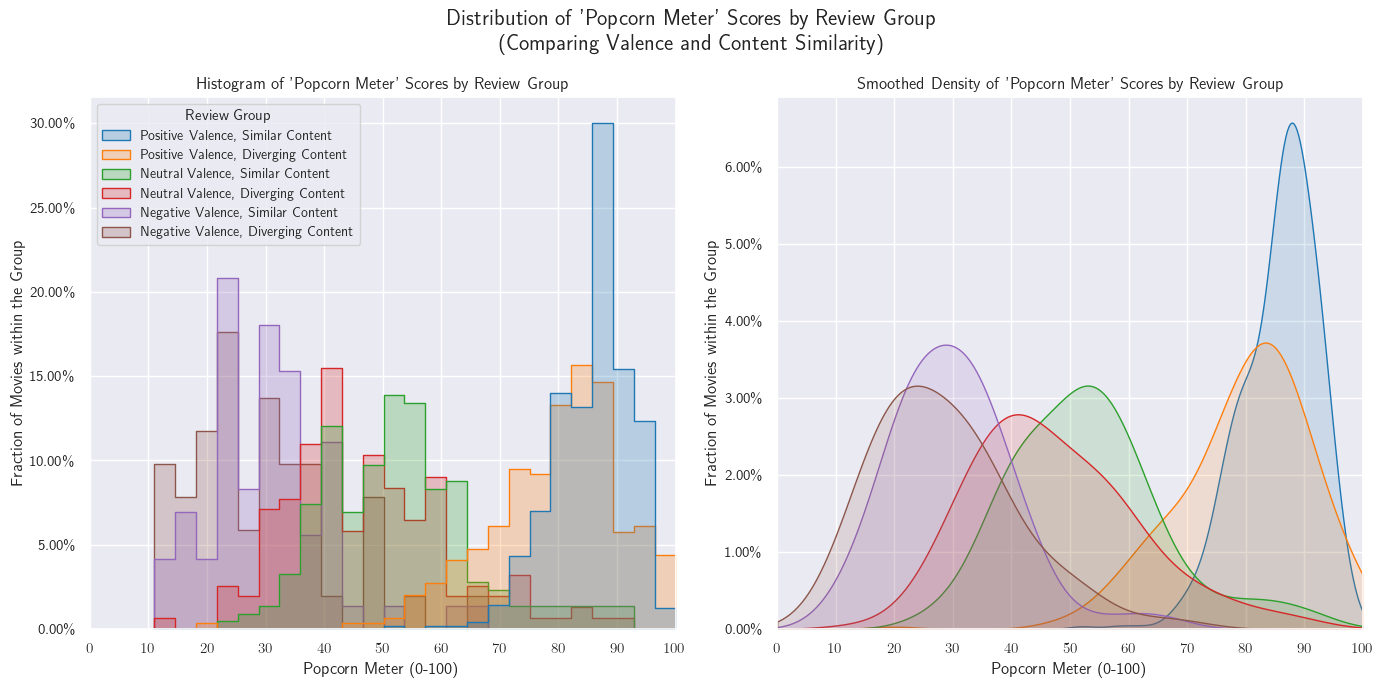

In [26]:
sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1,2, figsize=(14,7))
plt.suptitle("Distribution of 'Popcorn Meter' Scores by Review Group\n(Comparing Valence and Content Similarity)", fontweight="bold", fontsize=16)

# Histplot
sns.histplot(data=combined_groups, x="audienceScore", hue="group", bins=25, element="step", stat="probability", common_norm=False, palette=group_palette, ax=axes[0], legend=True)
axes[0].set_title("Histogram of 'Popcorn Meter' Scores by Review Group", fontweight="bold")

# Format automatically created legend
leg = axes[0].get_legend()
handles = leg.legend_handles
axes[0].legend(handles=handles, labels=leg_labels, title="Review Group", fontsize=10, title_fontsize=11)


# KDE
for group in combined_groups["group"].unique():
    sns.kdeplot(data=combined_groups[combined_groups["group"] == group], x="audienceScore", color=group_palette[group], bw_adjust=1.2, clip=(0, 100), ax=axes[1], fill=True, alpha=0.15)
axes[1].set_title("Smoothed Density of 'Popcorn Meter' Scores by Review Group", fontweight="bold")

# Common styling for Plots
for ax in axes:
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.set_xlabel("Popcorn Meter (0-100)")
    ax.set_ylabel("Fraction of Movies within the Group")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{100*y:.2f}\%'))

plt.tight_layout()
plt.show()

### Kruskal-Wallis H-Test (Test if the Distributions differ from each other)

In [27]:
# Test  H₀: distributions are identical
#       H₁: at least one distribution differs

groups = [g["audienceScore"].dropna() for _, g in combined_groups.groupby("group")]
H, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {H:.3f}, p = {p:.4f}")

Kruskal–Wallis H = 868.421, p = 0.0000


### Pairwise Mann-Whitney U-Tests

In [28]:
# Test  H₀: distributions are identical
#       H₁: distribution differ from each other

groups_dict = {name: g["audienceScore"].dropna() for name, g in combined_groups.groupby("group")}

pairs = []
for (g1, g2) in combinations(groups_dict.keys(), 2):
    u, p = stats.mannwhitneyu(groups_dict[g1], groups_dict[g2], alternative='two-sided')
    pairs.append([g1, g2, u, p])

results = pd.DataFrame(pairs, columns=["Group 1", "Group 2", "U-statistic", "p-value"])
results["p (Bonferroni)"] = results["p-value"] * len(results)
results["Significant"] = results["p (Bonferroni)"] < 0.05
print(results)

            Group 1          Group 2   U-statistic  p-value  p (Bonferroni)  Significant
0   highVal_diffCon  highVal_sameCon  47241.500000 0.000000        0.000000         True
1   highVal_diffCon   lowVal_diffCon  14905.500000 0.000000        0.000000         True
2   highVal_diffCon   lowVal_sameCon  21048.500000 0.000000        0.000000         True
3   highVal_diffCon  neutVal_diffCon  43338.500000 0.000000        0.000000         True
4   highVal_diffCon  neutVal_sameCon  58961.500000 0.000000        0.000000         True
5   highVal_sameCon   lowVal_diffCon  24781.000000 0.000000        0.000000         True
6   highVal_sameCon   lowVal_sameCon  34986.000000 0.000000        0.000000         True
7   highVal_sameCon  neutVal_diffCon  74026.500000 0.000000        0.000000         True
8   highVal_sameCon  neutVal_sameCon 101715.500000 0.000000        0.000000         True
9    lowVal_diffCon   lowVal_sameCon   1633.000000 0.298013        4.470193        False
10   lowVal_diffCon  

## Tomato Meter Distributions

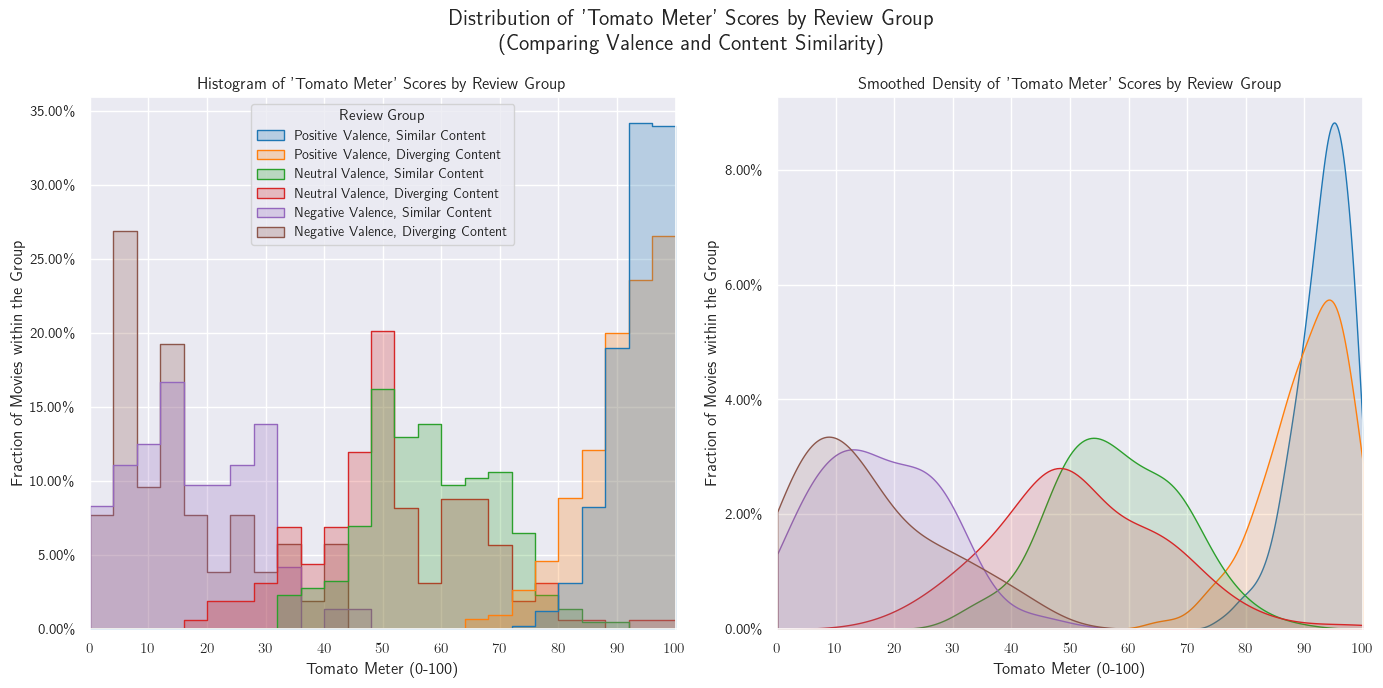

In [29]:
sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1,2, figsize=(14,7))
plt.suptitle("Distribution of 'Tomato Meter' Scores by Review Group\n(Comparing Valence and Content Similarity)", fontweight="bold", fontsize=16)

# Histplot
sns.histplot(data=combined_groups, x="tomatoMeter", hue="group", bins=25, element="step", stat="probability", common_norm=False, palette=group_palette, ax=axes[0], legend=True)
axes[0].set_title("Histogram of 'Tomato Meter' Scores by Review Group", fontweight="bold")

# Format automatically created legend
leg = axes[0].get_legend()
handles = leg.legend_handles
axes[0].legend(handles=handles, labels=leg_labels, title="Review Group", fontsize=10, title_fontsize=11)

# KDE
for group in combined_groups["group"].unique():
    sns.kdeplot(data=combined_groups[combined_groups["group"] == group], x="tomatoMeter", color=group_palette[group], bw_adjust=1.2, clip=(0, 100), ax=axes[1], fill=True, alpha=0.15)
axes[1].set_title("Smoothed Density of 'Tomato Meter' Scores by Review Group", fontweight="bold")

# Common styling
for ax in axes:
    ax.set_xlim(0, 100)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.set_xlabel("Tomato Meter (0-100)")
    ax.set_ylabel("Fraction of Movies within the Group")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{100*y:.2f}\%'))

plt.tight_layout()
plt.show()

### Kruskal-Wallis H-Test (Test if the Distributions differ from each other)

In [30]:
# Test  H₀: distributions are identical
#       H₁: at least one distribution differs

groups = [group["tomatoMeter"].dropna() for _, group in combined_groups.groupby("group")]
H, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {H:.3f}, p = {p:.4f}")

Kruskal–Wallis H = 949.920, p = 0.0000


### Pairwise Mann-Whitney U-Tests

In [31]:
# Test  H₀: distributions are identical
#       H₁: distribution differ from each other

groups_dict = {name: group["tomatoMeter"].dropna() for name, group in combined_groups.groupby("group")}

pairs = []
for (g1, g2) in combinations(groups_dict.keys(), 2):
    u, p = stats.mannwhitneyu(groups_dict[g1], groups_dict[g2], alternative='two-sided')
    pairs.append([g1, g2, u, p])

results = pd.DataFrame(pairs, columns=["Group 1", "Group 2", "U-statistic", "p-value"])
results["p (Bonferroni)"] = results["p-value"] * len(results)
results["Significant"] = results["p (Bonferroni)"] < 0.05
print(results)

            Group 1          Group 2   U-statistic  p-value  p (Bonferroni)  Significant
0   highVal_diffCon  highVal_sameCon  57961.000000 0.000000        0.000004         True
1   highVal_diffCon   lowVal_diffCon  15860.000000 0.000000        0.000000         True
2   highVal_diffCon   lowVal_sameCon  21960.000000 0.000000        0.000000         True
3   highVal_diffCon  neutVal_diffCon  47723.000000 0.000000        0.000000         True
4   highVal_diffCon  neutVal_sameCon  65293.500000 0.000000        0.000000         True
5   highVal_sameCon   lowVal_diffCon  25220.000000 0.000000        0.000000         True
6   highVal_sameCon   lowVal_sameCon  34920.000000 0.000000        0.000000         True
7   highVal_sameCon  neutVal_diffCon  76280.000000 0.000000        0.000000         True
8   highVal_sameCon  neutVal_sameCon 104578.000000 0.000000        0.000000         True
9    lowVal_diffCon   lowVal_sameCon   1580.500000 0.140359        2.105378        False
10   lowVal_diffCon  

## Box Office

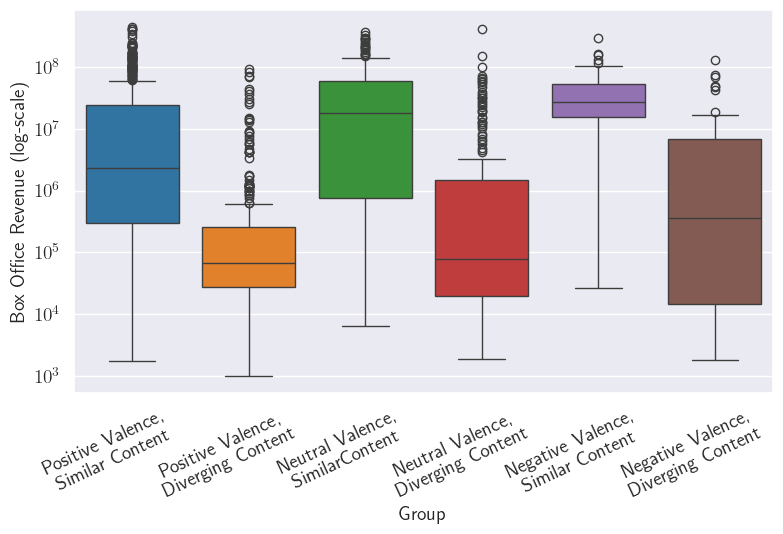

In [49]:
# Boxplot
fig, ax = plt.subplots(figsize=(8, 5.5))
sns.boxplot(data=combined_groups, x="group", y="boxOffice", hue="group", hue_order=group_order, palette=group_palette, ax=ax)
ax.set_yscale("log")
#ax.set_title("Box Office Distribution by Group", fontweight= "bold", fontsize=16)
ax.set_xlabel("Group", fontsize=14)
ax.set_ylabel("Box Office Revenue (log-scale)", fontsize=14)

xticks = ["Positive Valence,\nSimilar Content",
          "Positive Valence,\nDiverging Content",
          "Neutral Valence,\nSimilarContent",
          "Neutral Valence,\nDiverging Content",
          "Negative Valence,\nSimilar Content",
          "Negative Valence,\nDiverging Content"]

ticks = np.arange(len(group_order)) - 0.2 
ax.set_xticks(ticks)
ax.set_xticklabels(xticks, rotation=25, fontsize=14)
ax.tick_params(labelsize=14)


plt.tight_layout()
plt.show()

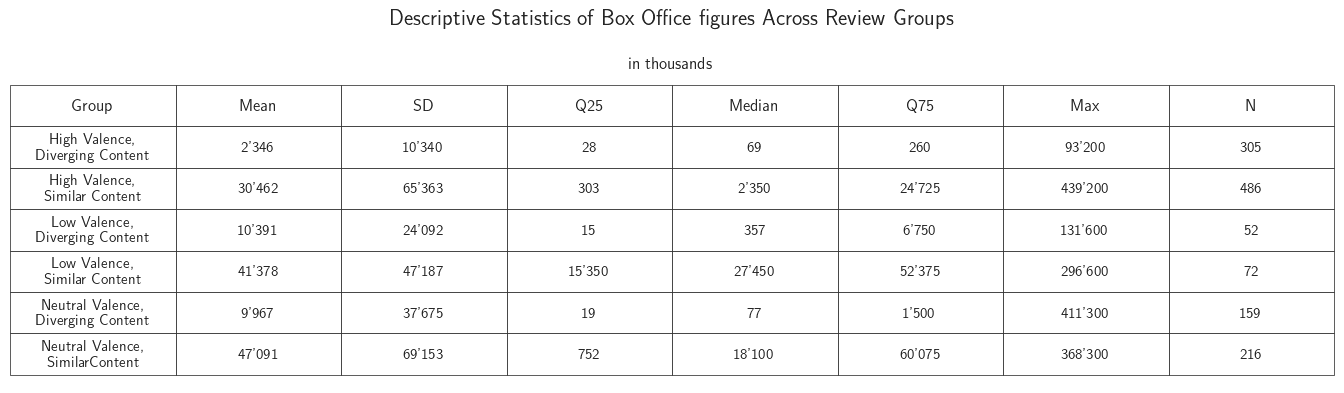

In [33]:
sns.set_theme(style="white")
plt.figure(figsize=(15,4))
plt.axis("off")
plt.suptitle("Descriptive Statistics of Box Office figures Across Review Groups", fontweight="bold", fontsize=16)
plt.title("in thousands", fontsize=12)

# Summary Statistics
summary = combined_groups.groupby("group").agg(Mean = ("boxOffice", "mean"),
                                        SD = ("boxOffice", "std"),
                                        Q25 = ("boxOffice", lambda x: x.quantile(0.25)),
                                        Median = ("boxOffice", lambda x: x.quantile(0.5)),
                                        Q75 = ("boxOffice", lambda x: x.quantile(0.75)),
                                        Max = ("boxOffice", "max"),
                                        N = ("boxOffice", "count")).reset_index().round({"Mean": 2, "SD": 2, "Q25": 2, "Median": 2, "Q75": 2, "Max": 0})

summary["group"] = summary["group"].replace({"highVal_sameCon": "High Valence,\nSimilar Content",
                                             "highVal_diffCon": "High Valence,\nDiverging Content",
                                             "neutVal_sameCon": "Neutral Valence,\nSimilarContent",
                                             "neutVal_diffCon": "Neutral Valence,\nDiverging Content",
                                             "lowVal_sameCon": "Low Valence,\nSimilar Content",
                                             "lowVal_diffCon": "Low Valence,\nDiverging Content"})
summary.rename(columns={"group": "Group"}, inplace=True)

# Format Numbers
def format_k(x):
    """Convert numbers to 'x' K format with apostrophes, e.g., 10'000 K"""
    return f"{x/1000:,.0f}".replace(",", "'")

for col in ["Mean", "SD", "Q25", "Median", "Q75", "Max"]:
    summary[col] = summary[col].apply(format_k)

# Create Table
table = plt.table(cellText = summary.values,
                      colLabels = summary.columns,
                      loc = "center",
                      cellLoc = "center")
table.scale(1.5, 2.5)

table.auto_set_font_size(False)
table.set_fontsize(11)
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
    if key[0] == 0:
        cell.set_fontsize(12)
        cell.set_text_props(weight="bold")

plt.tight_layout()
plt.show()

### Kruskal-Wallis H-Test (Test if the Distributions differ from each other)

In [34]:
# Test  H₀: distributions are identical
#       H₁: at least one distribution differs
groups = [g["boxOffice"].dropna() for _, g in combined_groups.groupby("group")]
H, p = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {H:.3f}, p = {p:.4f}")

Kruskal–Wallis H = 386.282, p = 0.0000


### Pairwise Mann-Whitney U-Tests

In [35]:
# Test  H₀: distributions are identical
#       H₁: distribution differ from each other

groups_dict = {name: g["boxOffice"].dropna() for name, g in combined_groups.groupby("group")}

pairs = []
for (g1, g2) in combinations(groups_dict.keys(), 2):
    u, p = stats.mannwhitneyu(groups_dict[g1], groups_dict[g2], alternative='two-sided')
    pairs.append([g1, g2, u, p])

results = pd.DataFrame(pairs, columns=["Group 1", "Group 2", "U-statistic", "p-value"])
results["p (Bonferroni)"] = results["p-value"] * len(results)
results["Significant"] = results["p (Bonferroni)"] < 0.05
print(results)

            Group 1          Group 2  U-statistic  p-value  p (Bonferroni)  Significant
0   highVal_diffCon  highVal_sameCon 26746.000000 0.000000        0.000000         True
1   highVal_diffCon   lowVal_diffCon  6523.000000 0.040880        0.613197        False
2   highVal_diffCon   lowVal_sameCon  1512.000000 0.000000        0.000000         True
3   highVal_diffCon  neutVal_diffCon 23149.500000 0.423357        6.350349        False
4   highVal_diffCon  neutVal_sameCon  9059.500000 0.000000        0.000000         True
5   highVal_sameCon   lowVal_diffCon 16655.500000 0.000162        0.002427         True
6   highVal_sameCon   lowVal_sameCon 10104.000000 0.000000        0.000000         True
7   highVal_sameCon  neutVal_diffCon 57279.000000 0.000000        0.000000         True
8   highVal_sameCon  neutVal_sameCon 40662.000000 0.000002        0.000028         True
9    lowVal_diffCon   lowVal_sameCon   597.500000 0.000000        0.000000         True
10   lowVal_diffCon  neutVal_dif

## Genre

## Percentage of Genre in Group

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1871/2162555066.py:49: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


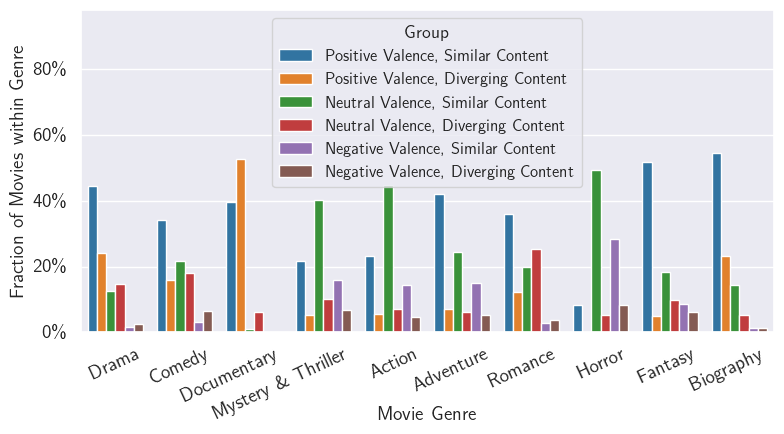

In [42]:
# Keep only genres with at least 75 movies
all_genres = combined_groups["genre"].explode()
valid_genres = all_genres.value_counts()
valid_genres = valid_genres[valid_genres >= 75].index

fractions = []

# Precompute total movies per genre
total_per_genre = (combined_groups.explode("genre").query("genre in @valid_genres")["genre"].value_counts())

# Compute P(group | genre)
for genre in valid_genres:
    genre_df = combined_groups[combined_groups["genre"].apply(lambda g: isinstance(g, list) and genre in g)]
    total = total_per_genre[genre]

    counts = genre_df["group"].value_counts()
    fraction = (counts / total).reset_index(name="fraction")
    fraction["genre"] = genre
    fractions.append(fraction)

fraction_data = pd.concat(fractions, ignore_index=True)

# Clean up genre names for plotting or LaTeX use
fraction_data["genre"] = fraction_data["genre"].str.replace("Mystery & thriller", r"Mystery \& Thriller")

# Plot
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(8, 4.5), constrained_layout=True)
#fig.suptitle("Proportions of Movies by Genre and Topic Consistency Group", fontweight="bold", fontsize=16)
#ax.set_title("Only Genres with 75 or more Movies are Shown")

sns.barplot(data=fraction_data, x="genre", y="fraction", hue="group", palette=group_palette, hue_order=group_order, ax=ax)

# Format legend and labels
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=leg_labels, title="Group",
          fontsize=12, title_fontsize=13)


ax.set_xlabel("Movie Genre", fontsize=14, labelpad=-12)
ax.set_ylabel("Fraction of Movies within Genre", fontsize=14)
ticks = np.arange(10) + 0.4 
ax.set_xticks(ticks)
plt.xticks(rotation=25, ha="right")
ax.tick_params(labelsize=14)
ax.set_ylim((0,0.98))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

plt.tight_layout()
plt.show()


## Age Rating (movies with no age restriction cannot be distinguished from movies with missing age ratings)

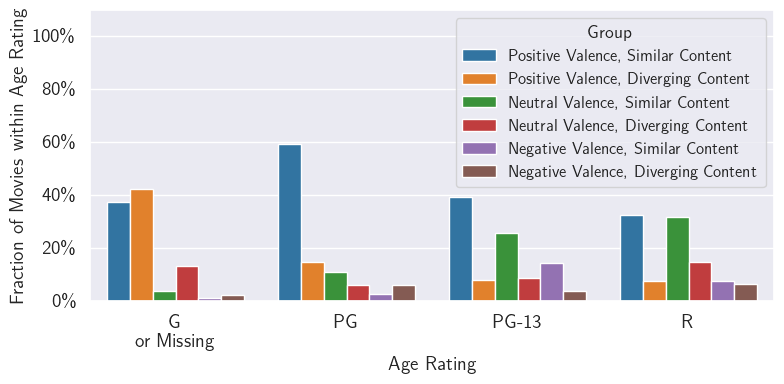

In [37]:
# Handle unrated observations
combined_groups.loc[pd.isnull(combined_groups["ageRating"]), "ageRating"] = "G \nor Missing"

# Drop NC-17 age rating (there is only one observation) and compute fraction
fraction_data = combined_groups.drop(combined_groups[combined_groups["ageRating"] == "NC-17"].index).groupby("ageRating")["group"].value_counts(normalize=True).rename("fraction").reset_index()

fraction_data["fraction"] = fraction_data["fraction"].astype(float)

sns.set_theme(style="darkgrid")
plt.figure(figsize=(8,4))
#plt.suptitle("Proportion of Movies by Age Rating and Topic Consistency Group", fontweight="bold", fontsize=16)

# Barchart
ax = sns.barplot(data=fraction_data, x="ageRating", y="fraction", hue="group", hue_order=group_order, palette=group_palette, order=fraction_data["ageRating"].value_counts().index, legend=True)

# Format the automatically created legend
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=leg_labels, title="Group",
          fontsize=12, title_fontsize=13)


ax.set_xlabel("Age Rating", fontsize=14)
ax.set_ylabel("Fraction of Movies within Age Rating", fontsize=14)
#plt.xticks(rotation=45, ha="right")
ax.tick_params(labelsize=14)
ax.set_ylim((0,1.1))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

plt.tight_layout()
plt.show()

## Release Year

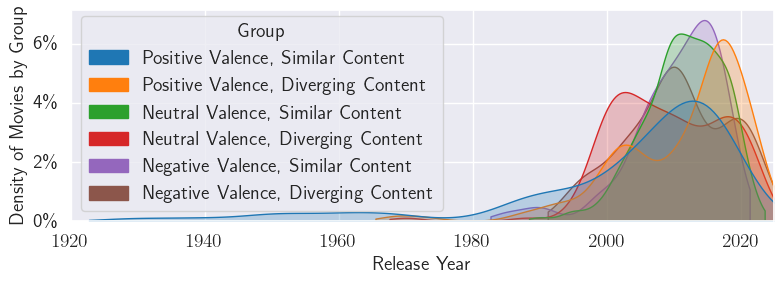

In [48]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(8,3))

#plt.suptitle("Distribution of Release Years by Valence / Topic Consistency Group", fontweight="bold", fontsize=16)

# KDE plot
ax = sns.kdeplot(data=combined_groups, x="releaseYear", hue="group", palette=group_palette, fill=True, common_norm=False, cut=1, bw_adjust=0.8, hue_order=group_order)

# Legend formatting
leg = ax.get_legend()
leg.set_title("Group")
plt.setp(leg.get_title(), fontsize=11, fontweight="bold")
plt.setp(leg.get_texts(), fontsize=10)

# Format the automatically created legend
handles = [
    mpatches.Patch(color=group_palette[g], label=leg_labels[i])
    for i, g in enumerate(group_order)
]

ax.legend(handles=handles, title="Group",
          fontsize=14, title_fontsize=14)


ax.set_xlabel("Release Year", fontsize=14)
ax.set_ylabel("Density of Movies by Group", fontsize=14)
ax.set_xlim((1920, 2025))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{100*y:.0f}\%'))
ax.tick_params( labelsize=14)

plt.tight_layout()
plt.show()

## Language

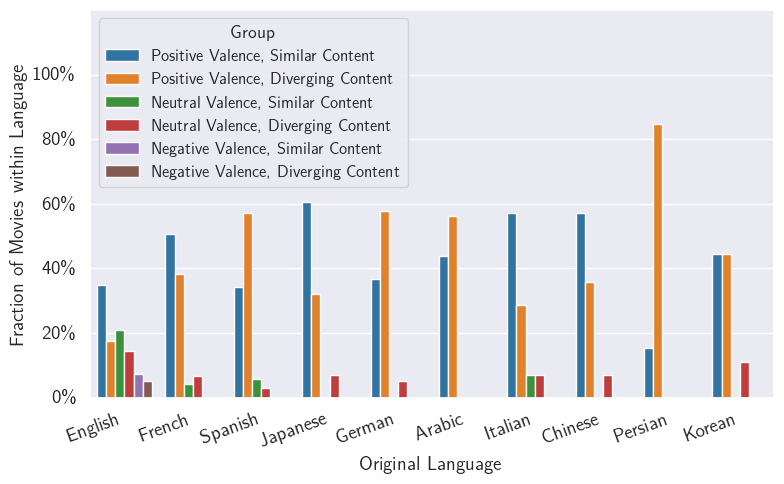

In [39]:
# Keep only languages top 10 languages
top12_langs = (combined_groups["originalLanguage"].value_counts().head(13).index)

filtered_data = combined_groups[combined_groups["originalLanguage"].isin(top12_langs)]

# Merge French
filtered_data.loc[(filtered_data["originalLanguage"] == "French (Canada)") | (filtered_data["originalLanguage"] == "French (France)"), "originalLanguage"] = "French"
# Merge English
filtered_data.loc[filtered_data["originalLanguage"] == "English (United Kingdom)", "originalLanguage"] = "English"

filtered_data.loc[filtered_data["originalLanguage"] == "Spanish (Spain)", "originalLanguage"] = "Spanish"

# Compute Fraction of movies per language within each group
fraction_data = filtered_data.groupby("originalLanguage")["group"].value_counts(dropna=False, normalize=True).rename("fraction").reset_index()


# Get language order
lang_order = filtered_data["originalLanguage"].value_counts().index


sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(8, 5))
#plt.suptitle("Proportion of Movies by Original Language and Topic Consistency Group", fontweight="bold", fontsize=16)
#ax.set_title("(Languages with fewer than 100 movies in the Data not shown)")

# Barchart
sns.barplot(data=fraction_data, x="originalLanguage", y="fraction", hue="group", hue_order=group_order, palette=group_palette, order=lang_order, legend=True, ax=ax)

# Format the automatically created legend
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=leg_labels, title="Group",
          fontsize=12, title_fontsize=13)


ax.set_xlabel("Original Language", fontsize=14)
ax.set_ylabel("Fraction of Movies within Language", fontsize=14)
ax.tick_params(labelsize=14)
plt.xticks(rotation=20, ha="right")
ax.set_ylim((0,1.2))
ax.set_yticks(np.linspace(0, 1, 6))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

plt.tight_layout()
plt.show()

## Director

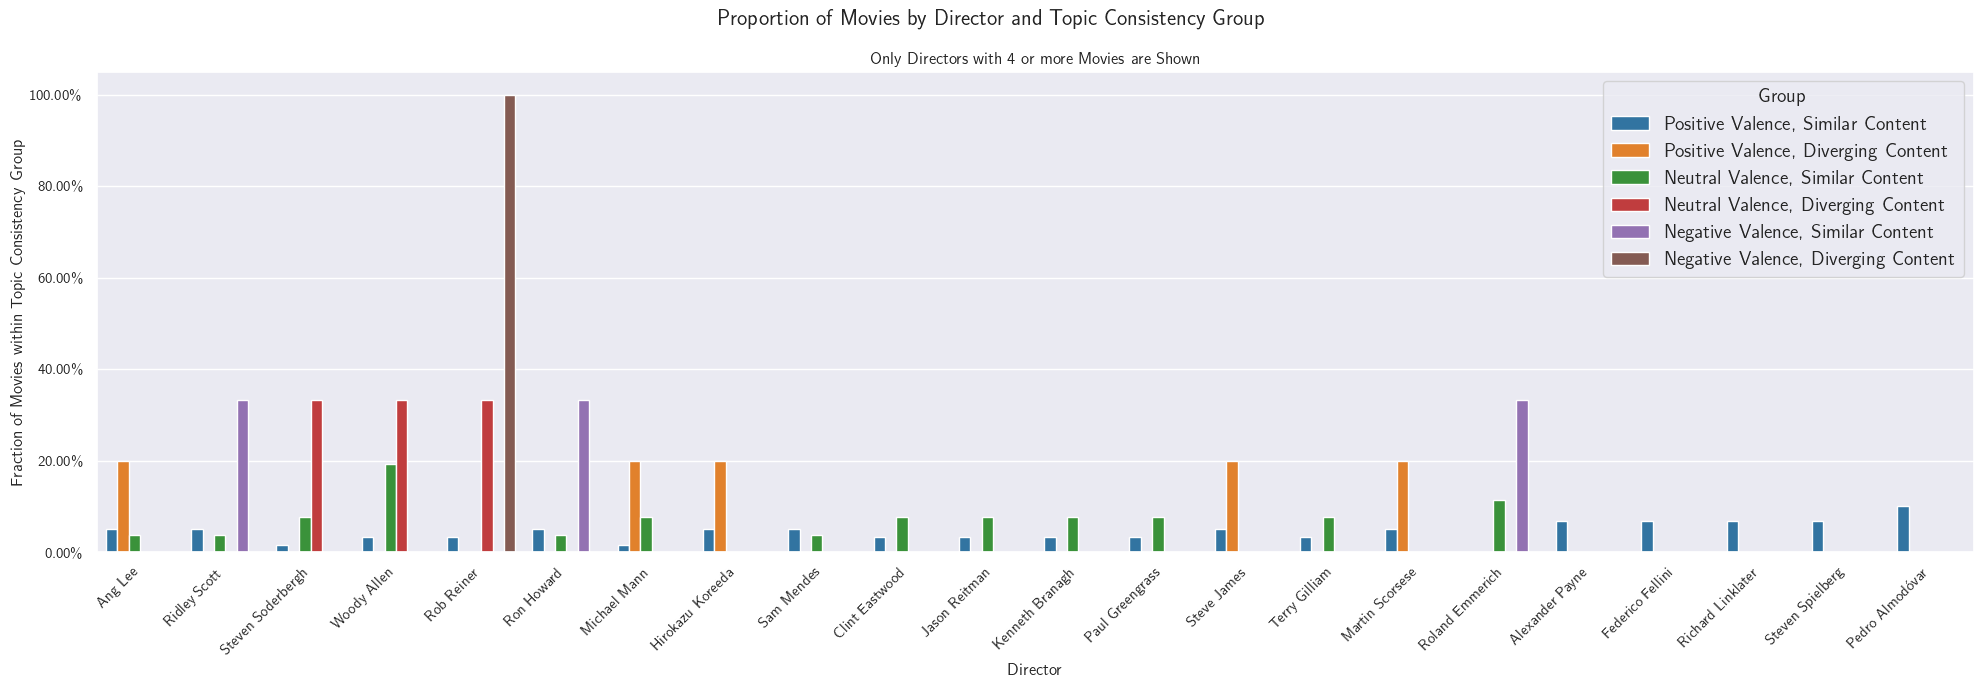

In [40]:
# Keep only directors with at least 4 movies in the data
dir_counts = combined_groups["director"].value_counts()
valid_dirs = dir_counts[dir_counts >= 4].index
filtered_data = combined_groups[combined_groups["director"].isin(valid_dirs)]

# Compute Fraction of movies per director within each group
fraction_data = filtered_data.groupby("group")["director"].value_counts(dropna=False, normalize=True).rename("fraction").reset_index()


sns.set_theme(style="darkgrid")
plt.figure(figsize=(20,7))
plt.suptitle("Proportion of Movies by Director and Topic Consistency Group", fontweight="bold", fontsize=16)
plt.title("Only Directors with 4 or more Movies are Shown")

# Barchart
ax = sns.barplot(data=fraction_data, x="director", y="fraction", hue="group", hue_order=group_order, palette=group_palette, order=fraction_data["director"].value_counts().index, legend=True)

# Format the automatically created legend
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=leg_labels, title="Group",
          fontsize=14, title_fontsize=14)


ax.set_xlabel("Director")
ax.set_ylabel("Fraction of Movies within Topic Consistency Group")
plt.xticks(rotation=45, ha="right")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=2))

plt.tight_layout()
plt.show()

## Runtime

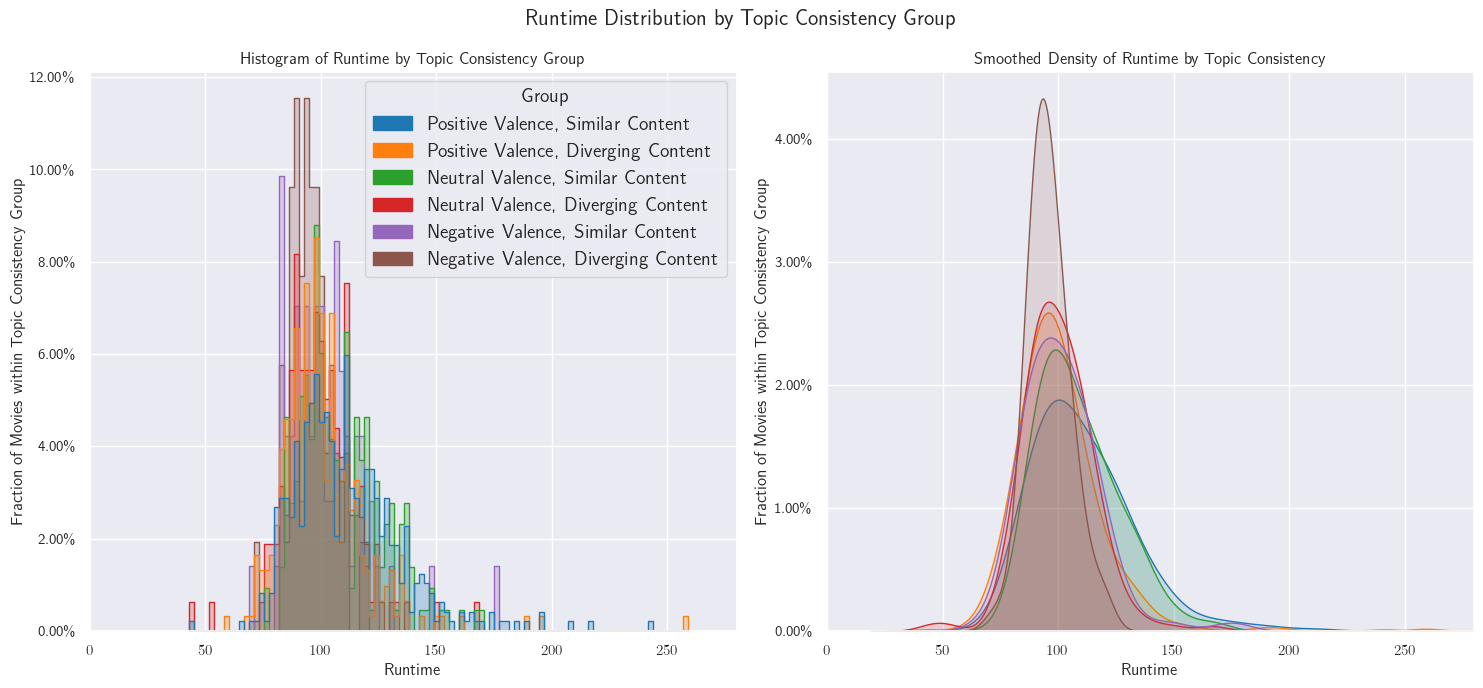

In [41]:
sns.set_theme(style="darkgrid")
fig, axes = plt.subplots(1,2, figsize=(15,7))
plt.suptitle("Runtime Distribution by Topic Consistency Group", fontweight="bold", fontsize=16)

# Histplot
sns.histplot(data=combined_groups, x="runtimeMinutes", hue="group", hue_order=group_order, palette=group_palette, bins=100, element="step", stat="probability", common_norm=False, ax=axes[0], legend=False)
axes[0].set_title("Histogram of Runtime by Topic Consistency Group", fontweight="bold")

# Format the automatically created legend
handles = [
    mpatches.Patch(color=group_palette[g], label=leg_labels[i])
    for i, g in enumerate(group_order)
]

axes[0].legend(handles=handles, title="Group",
          fontsize=14, title_fontsize=14)

# KDE
for group in combined_groups["group"].unique():
    sns.kdeplot(data=combined_groups[combined_groups["group"] == group], x="runtimeMinutes", color=group_palette[group], bw_adjust=1.2, clip=(0, 300), ax=axes[1], fill=True, alpha=0.15)
axes[1].set_title("Smoothed Density of Runtime by Topic Consistency", fontweight="bold")

# Common styling
for ax in axes:
    ax.set_xlim(0, 280)
    ax.set_xticks(np.arange(0, 290, 50))
    ax.set_xlabel("Runtime")
    ax.set_ylabel("Fraction of Movies within Topic Consistency Group")
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=2))

plt.tight_layout()
plt.show()